In [48]:
# 从sklearn 调入所需要的包
# from sklearn import datasets

import os
import json
import gc
# os.system('pip install numba')
from numba import jit
#tqdm
# os.system('pip install tqdm')
from tqdm import tqdm_notebook
from tqdm import tqdm

#Integrated model
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
# import xgboost as xgb

#base import 
import numpy as np
import pandas as pd

# about sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
#about time
import time
import datetime 
from datetime import datetime, timedelta

#Garbage collection
import gc
# scipy
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import scipy.spatial.distance as dist
#other
from collections import Counter 
from statistics import mode 
    #warning
import warnings
warnings.filterwarnings("ignore")
import json 
import math
from itertools import product
import ast
from sklearn.model_selection import train_test_split #数据分隔出训练集和验证集
import lightgbm as lgb
import numpy as np 
import pandas as pd
#导入精度和召回
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
pd.set_option('display.max_columns',None)

In [49]:
# 减少内存占用
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## 获取数据

In [50]:
path = "./"
train = pd.read_csv(path + "input/happiness_train_complete.csv", encoding="gbk")
test = pd.read_csv(path + "input/happiness_test_complete.csv", encoding="gbk")

In [51]:
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [52]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 140 entries, id to public_service_9
dtypes: float64(25), int64(111), object(4)
memory usage: 8.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Columns: 139 entries, id to public_service_9
dtypes: float64(23), int64(112), object(4)
memory usage: 3.1+ MB


(None, None)

In [53]:
train.describe()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,6880.000000,6028.000000,8.000000e+03,8000.000000,824.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,7996.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,7204.000000,7204.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,2951.000000,2951.000000,2951.000000,2951.000000,8000.000000,8000.000000,8000.000000,8000.000000,7.999000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.0,8000.000000,8000.000000,8000.000000,8000.000000,6934.000000,8000.000000,7172.000000,6282.000000,6230.000000,6282.000000,6282.000000,6282.000000,6.282000e+03,6282.000000,2565.000000,2565.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000
mean,4000.50000,3.850125,1.405500,15.155375,42.564750,70.619000,1.53000,1964.707625,1.37350,0.772250,1.427250,4.878375,3.505523,1574.742867,3.330734e+04,1.317750,1785.067961,115.302954,0.007875,0.473000,0.268500,0.101125,0.102750,0.023625,0.004000,0.022500,0.13600,163.989750,121.575625,3.598500,3.786250,3.819375,1.893750,1.375938,1.891875,1.710125,1.797375,3.915375,2.368625,1.60575,1.625250,4.496500,3.452375,3.762125,4.402625,3.756250,3.554000,3.591500,3.521500,4.713500,4.482125,3.427375,2.790625,3.291000,1.92650,3.474181,3.622432,1.825500,3.135125,4.192250,3.439625,4.445125,2.925375,2.979750,3.155202,14.500508,0.906811,2.652321,1.062125,1.232875,1.820875,1.835625,6.776050e+04,2.882500,2.595875,1.063625,1.817125,0.014875,0.909500,0.06150,0.020750,0.004750,0.001875,0.0,0.000750,0.000750,0.924375,0.767125,0.456879,3.234375,1825.481177,1963.963069,1868.025522,4.614454,1.319007,1.842566,2.836550e+04,2.838427,3.175828,0.963743,1108.42025,2.043500,1.079125,2.744625,1150.667250,1.550500,0.89900

In [54]:
test.describe()

,id,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
count,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2519.000000,2184.000000,2968.000000,2968.000000,302.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2667.000000,2667.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,1078.000000,1078.000000,1079.000000,1079.000000,2968.000000,2968.000000,2968.000000,2968.000000,2.968000e+03,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2586.000000,2968.000000,2667.000000,2319.000000,2291.000000,2319.000000,2319.000000,2319.000000,2.319000e+03,2319.000000,959.000000,959.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2.968000e+03,2968.000000,2968.000000,2968.00000,2968.000000,2968.00000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000
mean,9484.500000,1.422507,15.295485,42.943059,71.242588,1.537062,1964.320081,1.350404,0.772574,1.434636,4.801550,3.477173,1598.595238,24764.746968,1.341644,1750.447020,117.819340,0.008423,0.468666,0.263477,0.100067,0.107480,0.030323,0.004043,0.022237,0.131065,163.677898,120.819407,3.604784,3.819407,3.791105,1.879380,1.358154,1.889825,1.705526,1.798854,3.924865,2.312668,1.573113,1.604784,4.550876,3.432615,3.762129,4.422170,3.748315,3.566375,3.569407,3.491240,4.704852,4.509771,3.510445,2.824124,3.314690,1.919811,3.394076,3.566554,1.776954,3.122978,4.210916,3.463612,4.442722,2.920485,2.995620,3.116883,14.300557,0.911956,2.601483,1.066712,1.245620,1.823787,1.838275,6.244181e+04,2.879717,2.574124,1.081199,1.820081,0.016173,0.909030,0.056941,0.025606,0.005054,0.001011,0.000337,0.000674,0.000337,0.931267,0.818396,0.435035,3.263140,1841.760030,1963.881414,1888.013095,4.590341,1.301423,1.768435,2.768073e+04,2.806813,3.216893,0.989572,1134.498652,1.923854,1.117251,2.715296,1166.414420,1.495957,0.884434,4.050

In [55]:
train.corr()

,id,happiness,survey_type,province,city,county,gender,birth,nationality,religion,religion_freq,edu,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
id,1.000000,0.009560,-0.011345,-0.010624,-0.008390,-0.008109,0.021515,-0.000808,0.000470,0.002805,0.003557,0.016327,0.003359,0.014581,0.001647,0.010574,-0.002934,-0.004246,-0.009353,-0.028030,-0.004781,0.002373,-0.001862,0.010128,-0.000587,0.026434,0.013666,-0.017512,-0.024580,0.008466,0.003982,0.010735,0.018732,0.008080,0.010098,0.023473,0.011024,-0.002340,0.004755,0.007709,0.020170,-0.011373,-0.005153,-0.017008,-0.007150,-0.003008,-0.022876,-0.000981,-0.014163,-0.003011,-0.015646,0.001346,0.002917,0.008571,0.017032,-0.019992,-0.023678,0.006902,0.000947,0.008587,0.023512,-0.000649,0.018517,0.016033,0.021452,-0.026075,0.004710,0.003727,0.009830,-0.001802,0.008914,0.008087,0.016315,-0.007322,0.013052,-0.005744,-0.014820,-0.016138,-0.008354,0.013845,0.010483,0.012549,0.009432,NaN,-0.010220,-0.000696,-0.015193,0.019023,0.007368,0.007040,-0.015741,0.002333,-0.007180,0.028718,0.023786,0.006436,0.006227,-0.012352,-0.001302,-0.005825,-0.005900,0.011180,-0.018697,0.005200,0.002227,0.007890,-0.007184,0.004606,-0.004911,0.015799,0.015835,-0.014626,-0.007919,0.009002,-0.016133,-0.013565,-0.018801,-0.007583,-0.021084,-0.016482,0.002847,-0.016349,0.002837,-0.010224,-0.004779,-0.021787,-0.009623,0.010937,-0.001514,0.005270,0.006742,0.017411,0.011626,0.001778,0.007313,0.006183
happiness,0.009560,1.000000,-0.017043,-0.007333,-0.009733,-0.007544,0.022016,-0.007805,-0.018928,0.063539,0.002296,0.102945,0.040527,0.067897,0.024056,0.094677,0.052190,0.046945,-0.080732,-0.009040,0.040867,0.031487,0.016762,0.014323,0.010124,-0.011700,-0.042342,0.030380,0.074584,0.246979,0.182414,0.299933,0.057366,0.017320,0.097351,0.104797,0.099607,0.111960,0.060815,0.072850,-0.048054,0.025863,-0.035774,-0.055699,-0.005452,-0.051344,-0.030730,-0.059650,-0.106339,0.033427,0.017835,-0.035725,0.103588,0.134761,0.116214,0.001900,-0.056332,0.094388,0.245552,0.267328,0.152986,0.179701,0.110829,0.002564,0.026440,-0.009747,0.065813,0.020994,-0.002966,-0.017432,0.040919,0.037924,0.047654,0.054821,0.235988,0.103013,-0.012826,-0.045309,-0.026244,0.045332,0.038210,0.026539,0.010004,NaN,0.004377,0.009244,0.014468,0.059761,0.023391,-0.026026,0.071274,-0.007047,0.055198,0.134521,0.097660,0.085194,0.016738,-0.001833,0.046034,0.045890,0.048827,0.050413,0.018743,0.027535,0.054301,0.059320,0.011622,0.036026,-0.084743,-0.022892,0.112572,0.002179,-0.002001,0.084272,0.070737,-0.002978,-0.008420,0.137646,0.048084,0.075798,0.066609,0.058842,0.066100,0.001981,0.053695,0.060008,0.059083,0.116263,0.136942,0.142208,0.128396,0.133480,0.157128,0.147594,0.125048,0.132335
survey_type,-0.011345,-0.017043,1.000000,0.090110,0.087598,0.092077,-0.018017,-0.

## 数据探索

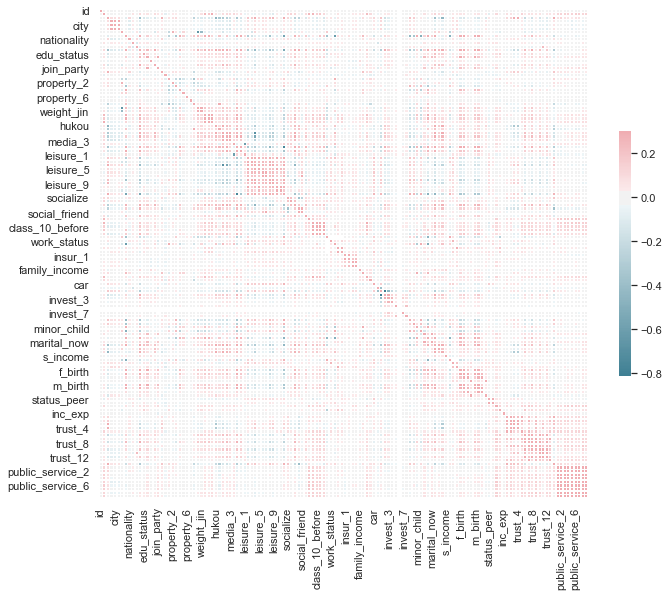

In [56]:
# 查询特征的相关性
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="white")
# 训练集各特征的相关性
corr = train.corr()
# 设置matplotlib f的尺寸
f,ax = plt.subplots(figsize=(11,9))
# 生成自定义的散色图
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# 设置热力图的长宽比
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, cbar_kws={"shrink":.5})
plt.show()

In [57]:
# 数据探索

In [58]:
train.shape, test.shape

((8000, 140), (2968, 139))

In [59]:
train.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
0,1,4,1,12,32,59,2015/8/4 14:18,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60,50,50,30.0,30,50,50,50
1,2,4,2,18,52,85,2015/7/21 15:04,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70,70,80,85.0,70,90,60,60
2,3,4,2,29,83,126,2015/7/21 13:24,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80,75,79,80.0,90,90,90,75
3,4,5,2,10,28,51,2015/7/25 17:33,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90,70,80,80.0,90,90,80,80
4,5,4,1,7,18,36,2015/8/10 9:50,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50,50,50,50.0,50,50,50,50


In [60]:
 # 时间特征：date_features = ['survey_time','marital_1st','marital_now']   

In [61]:
# 特征
features = [i for i in train.columns if i not in ["id", "happiness", "survey_time"]]
len(features)

137

In [62]:
# 类别特征1：categorical_features=['survey_type','province','city','county','gender','nationality'     
#,'religion','edu','edu_other','health','health_problem','depression',
#'hukou','hukou_loc','marital']

categorical_features1=['survey_type','province','city','county','gender','nationality'
,'religion','edu','edu_other','health','health_problem','depression', 'hukou','hukou_loc','marital'] 
len(categorical_features1)

15

In [63]:
#类别特征2 ：categorical_features2=[i for i in train.columns if 'property' in i]    
#类别特征3 ：categorical_features3=[i for i in train.columns if 'class' in i]    
#类别特征4 ：categorical_features4=[i for i in train.columns if 'insur_' in i]   
#类别特征5 ：categorical_features4=[i for i in train.columns if 'invest_' in i]   

categorical_features = [i for i in features if 'property' in i] + [i for i in features if 'class' in i] + [i for i in features if 'insur_' in i] + [i for i in features if 'invest_' in i] + categorical_features1
len(categorical_features)

43

In [64]:
#数值特征：numeric_features = ['religion_freq','floor_area','height_cm','weight_jin','socialize','relax','learn'   
#,'social_neighbor','social_friend','socia_outing','equity','house','car','son','daughter',    
#'minor_child','view','inc_ability','inc_exp','neighbor_familiarity'] 

#数值特征2：numeric_features2 = [i for i in train.columns if 'media' in i]    
#数值特征3：numeric_features3 = [i for i in train.columns if 'leisure' in i]    
#数值特征4：numeric_features4 = [i for i in train.columns if 'work_' in i]   
#数值特征5：numeric_features5 = [i for i in train.columns if 'family_' in i]   
#数值特征6：numeric_features6 = [i for i in train.columns if 's_' in i]   
#数值特征7：numeric_features7 = [i for i in train.columns if 'f_' in i]   
#数值特征8：numeric_features8 = [i for i in train.columns if 'm_' in i]   
#数值特征9：numeric_features9 = [i for i in train.columns if 'status_' in i]    
#数值特征10：numeric_features10 = [i for i in train.columns if 'status_' in i]   
#数值特征11：numeric_features11 = [i for i in train.columns if 'trust_' in i]   
#数值特征12：numeric_features11 = [i for i in train.columns if 'public_' in i]   

numeric_features = [i for i in features if i not in categorical_features]
len(numeric_features)

94

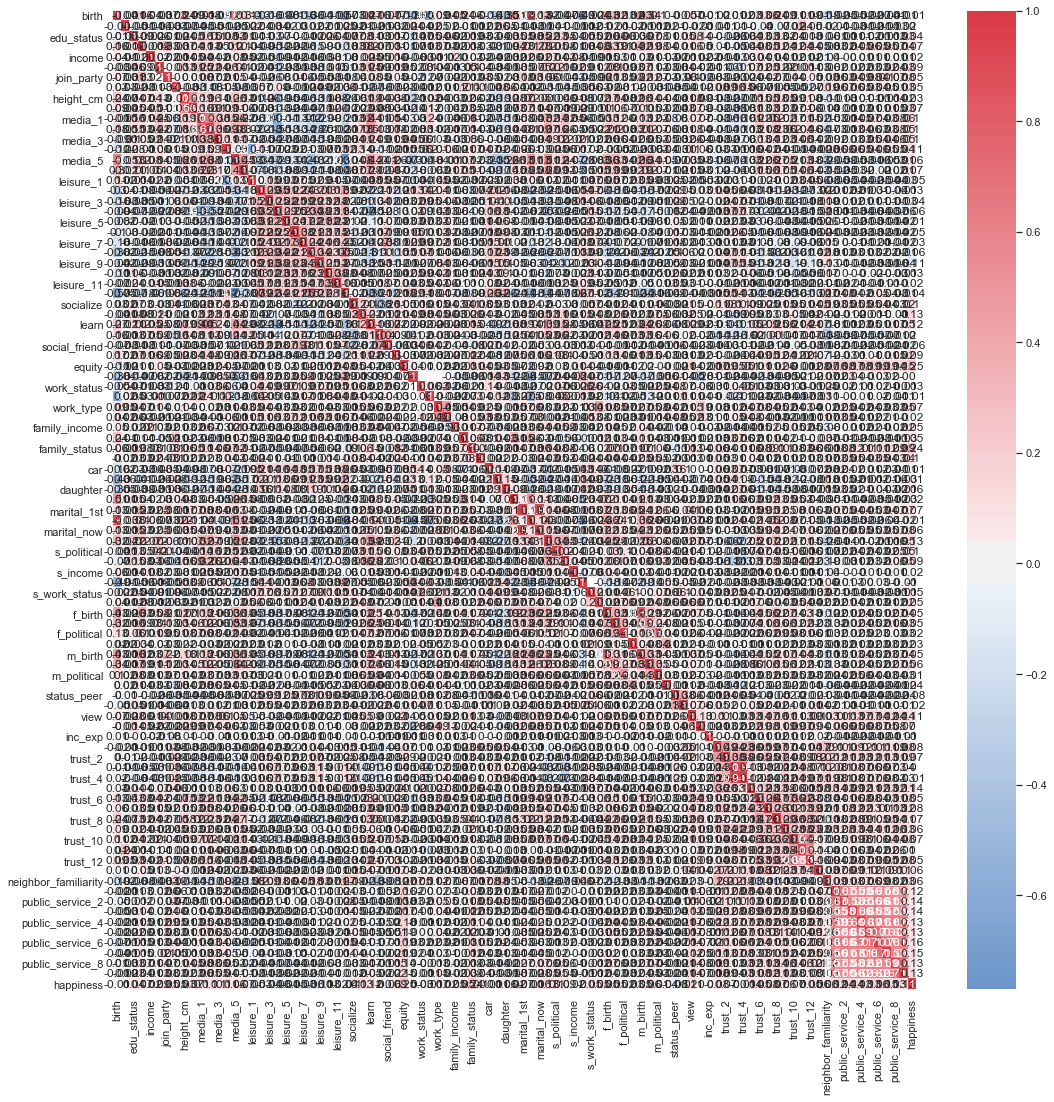

In [65]:
# 数值特征和happines的相关性
import seaborn as sns
from matplotlib import pyplot as plt
cor_matrix = train[numeric_features+['happiness']].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

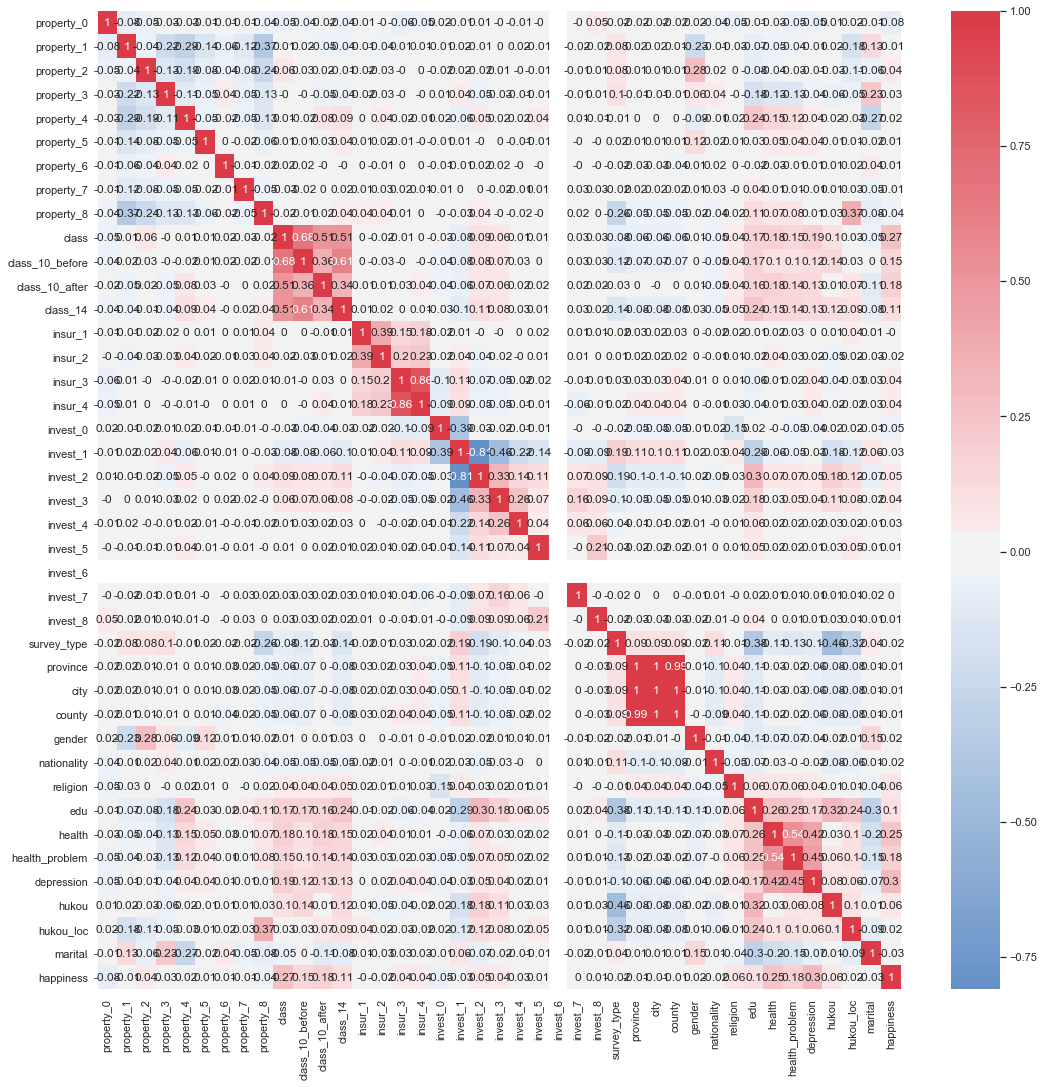

In [66]:
# 类别特征和happines的相关性
import seaborn as sns
from matplotlib import pyplot as plt
cor_matrix = train[categorical_features+['happiness']].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(18,18));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [67]:
# 二值特征
# import seaborn as sns
# from matplotlib import pyplot as plt
# cor_matrix = train[binary_features+['target']].corr().round(2)
# # Plotting heatmap 
# fig = plt.figure(figsize=(18,18));
# sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
# plt.show()

## 特征工程

In [68]:
# 查看数据是否缺失

train.info(verbose=True, null_counts=True)
# 或者 train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 140 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    8000 non-null   int64  
 1   happiness             8000 non-null   int64  
 2   survey_type           8000 non-null   int64  
 3   province              8000 non-null   int64  
 4   city                  8000 non-null   int64  
 5   county                8000 non-null   int64  
 6   survey_time           8000 non-null   object 
 7   gender                8000 non-null   int64  
 8   birth                 8000 non-null   int64  
 9   nationality           8000 non-null   int64  
 10  religion              8000 non-null   int64  
 11  religion_freq         8000 non-null   int64  
 12  edu                   8000 non-null   int64  
 13  edu_other             3 non-null      object 
 14  edu_status            6880 non-null   float64
 15  edu_yr              

In [69]:
# 缺失值统计

# 13  edu_other             3 non-null      object 
# 14  edu_status            6880 non-null   float64
# 15  edu_yr                6028 non-null   float64
# 18  join_party            824 non-null    float64
# 29  property_other        66 non-null     object 
# 36  hukou_loc             7996 non-null   float64
# 58  social_neighbor       7204 non-null   float64
# 59  social_friend         7204 non-null   float64
# 67  work_status           2951 non-null   float64
# 68  work_yr               2951 non-null   float64
# 69  work_type             2951 non-null   float64
# 70  work_manage           2951 non-null   float64
# 75  family_income         7999 non-null   float64
# 89  invest_other          29 non-null     object
# 92  minor_child           6934 non-null   float64
# 94  marital_1st           7172 non-null   float64
# 95  s_birth               6282 non-null   float64
# 96  marital_now           6230 non-null   float64
#  97  s_edu                 6282 non-null   float64
#  98  s_political           6282 non-null   float64
#  99  s_hukou               6282 non-null   float64
#  100 s_income              6282 non-null   float64
#  101 s_work_exper          6282 non-null   float64
#  102 s_work_status         2565 non-null   float64
#  103 s_work_type           2565 non-null   float64

### y Label

In [70]:
# 查看label的分布
y_train_ = train["happiness"]
y_train_.value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

In [71]:
train[train["happiness"] == -8]

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
609,610,-8,1,12,34,64,2015/8/9 15:30,2,1975,1,1,1,10,NaN,4.0,1997.0,-3,4,1998.0,95.0,0,0,0,0,0,0,0,0,1,NaN,160,95,5,5,5,4,1.0,1,1,1,2,5,2,1,4,4,4,4,3,2,2,2,4,3,1,3,3,3,3.0,3.0,-8,3,5,5,5,5,1,2.0,10.0,2.0,4.0,2,2,1,2,200000.0,6,3,1,1,0,0,1,0,0,0,0,0,0,NaN,1,1,2.0,3,2001.0,1975.0,2001.0,13.0,2.0,4.0,200000.0,1.0,3.0,1.0,-2,3,1,1,-2,4,1,5,2,2,4,2,100000.0,4,3,4,4,5,4,3,3,3,4,4,4,3,2,70,60,50,60,60.0,60,70,60,60
1064,1065,-8,1,12,32,58,2015/9/1 19:55,2,1965,1,1,1,6,NaN,4.0,-2.0,-2,1,NaN,50.0,1,0,0,0,0,0,0,0,0,NaN,157,100,3,3,3,2,1.0,3,2,5,3,3,1,2,5,4,2,5,4,4,4,3,5,5,2,3,2,2,6.0,5.0,2,1,7,5,8,5,1,3.0,20.0,1.0,3.0,2,2,2,2,-3.0,3,3,-3,2,0,1,0,0,0,0,0,0,0,NaN,0,1,1.0,3,1997.0,1965.0,1997.0,12.0,1.0,2.0,-3.0,1.0,3.0,1.0,-2,-8,1,1,-2,-8,1,-8,2,2,3,3,60000.0,4,4,-8,-8,4,3,3,4,-8,-8,-8,-8,1,3,80,80,80,80,80.0,70,70,80,70
1419,1420,-8,1,1,1,3,2015/9/29 13:14,1,1971,1,-8,1,-8,NaN,-8.0,-3.0,-3,-8,NaN,100.0,1,0,0,0,0,0,0,0,0,NaN,177,165,-8,-8,-8,2,1.0,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8.0,-8.0,-8,-8,-8,-8,-8,-8,1,-8.0,-3.0,-8.0,-8.0,1,-1,-1,-1,-3.0,4,-8,-3,-8,1,0,0,0,0,0,0,0,0,NaN,1,1,2.0,3,-3.0,1971.0,-3.0,-8.0,-8.0,-8.0,-3.0,1.0,-8.0,1.0,-3,-8,-8,-8,-3,-8,-8,-8,-8,-8,-8,-8,-3.0,3,3,3,3,3,3,3,3,3,3,3,3,3,3,60,60,60,60,60.0,60,60,60,60
1702,1703,-8,1,24,71,111,2015/8/3 19:35,1,1950,1,0,1,3,NaN,2.0,NaN,10000,1,NaN,94.0,0,1,1,0,0,0,0,0,0,NaN,172,150,5,5,5,5,1.0,1,1,3,3,1,1,3,-8,3,5,5,5,3,3,5,5,5,5,4,4,1,7.0,3.0,1,3,2,2,5,2,1,3.0,40.0,1.0,3.0,1,2,2,2,-3.0,4,3,1,2,0,1,0,0,0,0,0,0,0,NaN,1,1,0.0,3,1984.0,1960.0,1984.0,1.0,1.0,5.0,0.0,5.0,NaN,NaN,-2,1,1,1,-2,-8,1,15,2,2,3,2,150000.0,5,-8,-8,-8,5,4,3,4,3,3,3,3,1,5,90,70,80,80,80.0,80,80,90,90
2700,2701,-8,1,1,1,3,2015/9/29 10:42,1,1971,1,-8,1,-8,NaN,-8.0,-3.0,-3,-8,NaN,100.0,1,0,0,0,0,0,0,0,0,NaN,175,160,-8,-8,-8,2,1.0,3,-8,-8,4,4,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8.0,-8.0,-8,3,-8,-8,-8,-8,1,-8.0,-3.0,-8.0,-8.0,-8,-8,-8,-8,-3.0,-3,-8,-3,-8,1,0,0,0,0,0,0,0,0,NaN,-8,-8,-8.0,3,-2.0,1972.0,-3.0,-8.0,-8.0,-8.0,-3.0,1.0,-8.0,-8.0,-3,-8,-8,-8,-3,-8,-8,-8,-8,-8,-8,-8,-3.0,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,2,60,60,60,60,60.0,60,60,60,60
2884,2885,-8,1,12,33,62,2015/8/9 15:28,1,1976,1,0,4,3,NaN,2.0,NaN,-2,1,NaN,54.0,0,1,0,0,0,0,0,0,0,NaN,170,125,4,4,4,1,1.0,1,1,1,2,1,1,3,5,5,5,5,4,5,5,5,5,5,5,3,3,1,-8.0,4.0,1,2,-8,-8,-8,-8,2,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,-8,1,2,0,1,0,0,0,0,0,0,0,NaN,2,0,1.0,3,-2.0,1976.0,-2.0,3.0,1.0,1.0,-2.0,4.0,NaN,NaN,-2,1,1,2,-2,1,1,2,3,2,-8,-8,-2.0,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,-8,3,-2,-2,-2,-2,-2.0,-2,-2,-2,-2
3058,3059,-8,2,31,87,132,2

In [72]:
# 将-8换成3
y_train_ = y_train_.map(lambda x: 3 if x==-8 else x)

# label从0开始
y_train_ = y_train_.map(lambda x: x-1)

In [73]:
# 将train和test连接在一起
# test['happiness']=-1
# data = train.append(test).reset_index(drop=True)

data = pd.concat([train, test], axis=0, ignore_index=True)
data.shape

(10968, 140)

In [74]:
data.tail() # test的happines填充Nan

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9
10963,10964,NaN,1,27,77,117,2015/7/19 20:01,2,1946,1,1,1,3,NaN,2.0,NaN,1720,1,NaN,45.0,0,0,0,0,0,0,0,0,1,NaN,170,150,1,3,3,1,2.0,2,2,3,4,1,1,1,5,5,5,5,4,4,5,4,5,4,5,4,4,2,1.0,1.0,1,5,8,8,10,7,1,3.0,6.0,1.0,3.0,1,2,2,2,-2.0,2,2,7,2,0,1,0,0,0,0,0,0,0,NaN,2,0,2.0,7,1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1932,3,1,2,1925,2,1,2,1,1,4,3,10000.0,4,4,4,4,3,5,5,5,5,5,5,5,2,5,50,60.0,60,70,50.0,60,40,60,50
10964,10965,NaN,2,26,74,114,2015/8/8 13:09,2,1977,1,1,1,4,NaN,2.0,-1.0,10000,1,NaN,600.0,0,1,0,0,0,0,0,0,0,NaN,150,100,4,4,3,1,1.0,1,1,1,4,1,1,1,4,4,5,5,4,4,5,5,5,5,5,3,1,1,3.0,4.0,4,3,4,3,5,1,3,NaN,NaN,NaN,NaN,1,2,2,2,20000.0,4,3,1,2,0,1,0,0,0,0,0,0,0,NaN,1,1,2.0,3,1998.0,1975.0,1998.0,3.0,1.0,1.0,10000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,3,2,-2.0,4,4,4,3,3,2,2,1,1,1,1,1,1,3,60,50.0,70,50,50.0,50,50,50,50
10965,10966,NaN,2,29,84,127,2015/7/22 9:29,2,1968,1,1,1,1,NaN,NaN,NaN,15000,1,NaN,100.0,0,0,1,0,0,0,0,0,0,NaN,165,110,2,3,4,1,1.0,1,1,1,4,1,1,1,3,3,5,5,4,4,5,5,5,5,5,2,3,1,2.0,2.0,1,4,5,1,7,2,3,NaN,NaN,NaN,NaN,1,1,2,2,30000.0,2,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,3,0.0,3,1989.0,1962.0,1989.0,4.0,1.0,1.0,15000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,20000.0,4,4,4,4,4,-8,-8,-8,2,-8,-8,-8,2,4,60,60.0,60,60,60.0,60,60,60,60
10966,10967,NaN,1,11,31,54,2015/7/20 16:06,1,1950,1,1,1,7,NaN,4.0,-2.0,-1,1,NaN,130.0,0,1,0,0,0,0,0,0,0,NaN,168,120,4,5,5,1,1.0,1,1,1,5,1,1,1,5,5,5,5,5,5,5,5,5,5,5,1,2,2,NaN,NaN,1,2,2,1,2,2,4,NaN,NaN,NaN,NaN,1,1,2,2,-1.0,2,3,1,2,0,1,0,0,0,0,0,0,0,NaN,1,1,0.0,3,1988.0,1950.0,1988.0,7.0,1.0,-8.0,-1.0,4.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,-8,-3.0,5,5,5,5,5,5,5,5,5,5,5,5,5,3,84,60.0,70,87,90.0,80,80,80,80
10967,10968,NaN,1,13,37,68,2015/9/3 9:59,1,1941,1,1,1,4,NaN,2.0,1954.0,12000,1,NaN,135.0,0,1,1,0,0,0,0,0,0,NaN,164,110,5,5,5,2,1.0,4,2,1,4,1,1,1,5,5,2,5,4,4,5,4,5,5,5,4,4,3,2.0,5.0,1,5,8,6,8,1,5,NaN,NaN,NaN,NaN,1,1,2,2,74000.0,5,3,1,2,0,1,0,0,0,0,0,0,0,NaN,1,2,0.0,3,1970.0,1941.0,1970.0,3.0,1.0,2.0,12000.0,5.0,NaN,NaN,-2,-8,-8,1,-2,6,-8,1,2,2,4,2,36000.0,4,4,-8,-8,5,-8,4,4,4,-8,-8,-8,3,5,90,90.0,90,90,90.0,90,90,90,90


In [75]:
#####  类别特征 LabelEncoder
# cat_col = categorical_features
# for i in tqdm_notebook(cat_col):
# #     lbl = LabelEncoder()
#     data['count_' + i] = data.groupby([i])[i].transform('count')
# #     data[i] = lbl.fit_transform(data[i].astype(str))

In [76]:
##### One-hot 类别特征
# for column in categorical_features:
#     temp = pd.get_dummies(pd.Series(data[column]))
#     data = pd.concat([data, temp], axis = 1)
#     data = data.drop([column], axis=1)

### 时间特征

In [77]:
# 处理时间特征
data["survey_time"] = pd.to_datetime(data["survey_time"], format="%Y-%m-%d %H:%M:%S")
data["weekday"] = data["survey_time"].dt.weekday
data["year"] = data["survey_time"].dt.year
data["quarter"] = data["survey_time"].dt.quarter
data["hour"] = data["survey_time"].dt.hour
data["month"] = data["survey_time"].dt.month

In [78]:
data.head()

,id,happiness,survey_type,province,city,county,survey_time,gender,birth,nationality,religion,religion_freq,edu,edu_other,edu_status,edu_yr,income,political,join_party,floor_area,property_0,property_1,property_2,property_3,property_4,property_5,property_6,property_7,property_8,property_other,height_cm,weight_jin,health,health_problem,depression,hukou,hukou_loc,media_1,media_2,media_3,media_4,media_5,media_6,leisure_1,leisure_2,leisure_3,leisure_4,leisure_5,leisure_6,leisure_7,leisure_8,leisure_9,leisure_10,leisure_11,leisure_12,socialize,relax,learn,social_neighbor,social_friend,socia_outing,equity,class,class_10_before,class_10_after,class_14,work_exper,work_status,work_yr,work_type,work_manage,insur_1,insur_2,insur_3,insur_4,family_income,family_m,family_status,house,car,invest_0,invest_1,invest_2,invest_3,invest_4,invest_5,invest_6,invest_7,invest_8,invest_other,son,daughter,minor_child,marital,marital_1st,s_birth,marital_now,s_edu,s_political,s_hukou,s_income,s_work_exper,s_work_status,s_work_type,f_birth,f_edu,f_political,f_work_14,m_birth,m_edu,m_political,m_work_14,status_peer,status_3_before,view,inc_ability,inc_exp,trust_1,trust_2,trust_3,trust_4,trust_5,trust_6,trust_7,trust_8,trust_9,trust_10,trust_11,trust_12,trust_13,neighbor_familiarity,public_service_1,public_service_2,public_service_3,public_service_4,public_service_5,public_service_6,public_service_7,public_service_8,public_service_9,weekday,year,quarter,hour,month
0,1,4.0,1,12,32,59,2015-08-04 14:18:00,1,1959,1,1,1,11,NaN,4.0,-2.0,20000,1,NaN,45.0,0,1,0,0,0,0,0,0,0,NaN,176,155,3,2,5,5,2.0,4,2,5,5,4,3,1,4,3,1,2,3,4,1,4,5,4,1,2,4,3,3.0,3.0,2,3,3,3,3,1,1,3.0,30.0,1.0,2.0,1,1,1,2,60000.0,2,2,1,2,0,1,0,0,0,0,0,0,0,NaN,1,0,0.0,3,1984.0,1958.0,1984.0,6.0,1.0,5.0,40000.0,5.0,NaN,NaN,-2,4,4,1,-2,4,1,1,3,2,4,3,50000.0,4,2,-8,-8,5,3,2,3,4,3,-8,4,1,4,50,60.0,50,50,30.0,30,50,50,50,1,2015,3,14,8
1,2,4.0,2,18,52,85,2015-07-21 15:04:00,1,1992,1,1,1,12,NaN,4.0,2013.0,20000,1,NaN,110.0,0,0,0,0,1,0,0,0,0,NaN,170,110,5,4,3,1,1.0,2,2,1,3,5,1,2,3,4,3,5,4,3,2,3,4,5,1,2,4,3,6.0,2.0,1,3,6,4,8,5,1,3.0,2.0,1.0,3.0,1,1,1,1,40000.0,3,4,1,2,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972,3,1,2,1973,3,1,2,1,1,4,2,50000.0,5,4,4,3,5,3,3,3,2,3,3,3,2,3,90,70.0,70,80,85.0,70,90,60,60,1,2015,3,15,7
2,3,4.0,2,29,83,126,2015-07-21 13:24:00,2,1967,1,0,3,4,NaN,4.0,-2.0,2000,1,NaN,120.0,0,1,1,0,0,0,0,0,0,NaN,160,122,4,4,5,1,1.0,2,2,2,5,1,3,1,4,4,3,5,4,4,2,3,5,5,5,3,4,2,2.0,5.0,2,4,5,4,6,3,2,NaN,NaN,NaN,NaN,1,1,2,2,8000.0,3,3,1,2,0,1,0,0,0,0,0,0,0,NaN,0,2,1.0,3,1990.0,1968.0,1990.0,3.0,1.0,1.0,6000.0,3.0,NaN,NaN,-2,1,1,2,-2,1,1,2,2,1,4,2,80000.0,3,3,3,3,4,3,3,3,3,3,-8,3,1,4,90,80.0,75,79,80.0,90,90,90,75,1,2015,3,13,7
3,4,5.0,2,10,28,51,2015-07-25 17:33:00,2,1943,1,1,1,3,NaN,4.0,1959.0,6420,1,NaN,78.0,0,0,0,1,0,0,0,0,0,NaN,163,170,4,4,4,1,2.0,2,1,1,5,1,1,1,5,2,4,5,4,5,1,1,5,5,5,2,4,4,1.0,6.0,1,4,5,5,7,2,4,NaN,NaN,NaN,NaN,2,2,2,2,12000.0,3,3,1,1,0,1,0,0,0,0,0,0,0,NaN,1,4,0.0,7,1960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2,14,1,2,-2,1,1,2,2,1,3,2,10000.0,3,3,4,3,5,3,3,5,4,3,3,3,2,3,100,90.0,70,80,80.0,90,90,80,80,5,2015,3,17,7
4,5,4.0,1,7,18,36,2015-08-10 09:50:00,2,1994,1,1,1,12,NaN,1.0,2014.0,-1,2,NaN,70.0,0,0,0,0,1,0,0,0,0,NaN,165,110,5,5,3,2,3.0,1,3,4,2,5,5,3,3,3,2,4,4,3,5,2,5,5,1,4,3,4,7.0,5.0,3,2,1,1,1,4,6,NaN,NaN,NaN,NaN,1,2,2,2,-2.0,4,3,1,1,0,1,0,0,0,0,0,0,0,NaN,0,0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970,6,1,10,1972,4,1,15,3,2,3,-8,200000.0,4,3,3,3,5,5,3,4,3,3,3,3,2,2,50,50.0,50,50,50.0,50,50,50,50,0,2015,3,9,8


In [79]:
# 把一天的时间分段
def hour_cut(x):
    if 0<=6:
        return 0
    elif 6<=x<8:
        return 1
    elif 8<=x<12:
        return 2
    elif 12<=x<14:
        return 3
    elif 14<=x<18:
        return 4
    elif 18<=x<21:
        return 5
    elif 21<=x<24:
        return 6

data["hour_cut"] = data["hour"].map(hour_cut)

In [80]:
# 做调查问卷时候的特征
data["survey_age"] = data["year"] - data["birth"]

In [81]:
# data.info(verbose=True, null_counts=True)

### data label

In [82]:
#让label从0开始
data["happiness"] = data["happiness"].map(lambda x: x-1)

In [83]:
data.happiness.value_counts()

 3.0    4818
 4.0    1410
 2.0    1159
 1.0     497
 0.0     104
-9.0      12
Name: happiness, dtype: int64

In [84]:
#去掉缺失值较多的
data = data.drop(["edu_other"], axis=1)
data = data.drop(["happiness"], axis=1)
data = data.drop(["survey_time"], axis=1)

### 其他特征

In [85]:
# 是否入党d
data["join_party"] = data["join_party"].map(lambda x: 0 if pd.isnull(x) else 1)

In [86]:
# 出生的年代
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7

data["birth_s"] = data["birth"].map(birth_split)

In [87]:
# 收入分组
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5

data["income_cut"]=data["income"].map(income_cut)

### 填充缺失值

In [88]:
# 缺失值填充
data["edu_status"]=data["edu_status"].fillna(5)
data["edu_yr"]=data["edu_yr"].fillna(-2)
data["property_other"]=data["property_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["hukou_loc"]=data["hukou_loc"].fillna(1)
data["social_neighbor"]=data["social_neighbor"].fillna(8)
data["social_friend"]=data["social_friend"].fillna(8)
data["work_status"]=data["work_status"].fillna(0)
data["work_yr"]=data["work_yr"].fillna(0)
data["work_type"]=data["work_type"].fillna(0)
data["work_manage"]=data["work_manage"].fillna(0)
data["family_income"]=data["family_income"].fillna(-2)
data["invest_other"]=data["invest_other"].map(lambda x:0 if pd.isnull(x)  else 1)
data["minor_child"]=data["minor_child"].fillna(0)
data["marital_1st"]=data["marital_1st"].fillna(0)
data["s_birth"]=data["s_birth"].fillna(0)
data["marital_now"]=data["marital_now"].fillna(0)
data["s_edu"]=data["s_edu"].fillna(0)
data["s_political"]=data["s_political"].fillna(0)
data["s_hukou"]=data["s_hukou"].fillna(0)
data["s_income"]=data["s_income"].fillna(0)
data["s_work_exper"]=data["s_work_exper"].fillna(0)
data["s_work_status"]=data["s_work_status"].fillna(0)
data["s_work_type"]=data["s_work_type"].fillna(0)

In [89]:
# 删除id列
data = data.drop(["id"], axis=1)

In [90]:
# # 填充test的label
# data["happiness"]=data["happiness"].fillna(-1)

In [91]:
data.shape

(10968, 145)

In [96]:
X_train_ = data[:train.shape[0]]
X_test_ = data[train.shape[0]:]

target_column = 'happiness'
feature_columns=list(X_test_.columns) 
len(feature_columns)

145

In [93]:
# # LabelEncoder
# cat_col = [i for i in data.select_dtypes(object).columns if i not in ["id", "survey_time", "happiness"]]
# print(cat_col)
# for i in tqdm_notebook(cat_col):
#     lbl = LabelEncoder()
#     #  data['count_' + i] = data.groupby([i])[i].transform('count')   ->增加count特征
#     data[i] = lbl.fit_transform(data[i].astype(str))

In [94]:
# data.head()

## 模型

In [97]:
X_train = np.array(X_train_)
y_train = np.array(y_train_)
X_test  = np.array(X_test_)

In [98]:
X_train.shape

(8000, 145)

In [102]:
from sklearn.metrics import mean_squared_error
#自定义评价函数
def myFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)
    return 'myFeval',score

### xgb

In [103]:
import xgboost as xgb
# 参数
xgb_params = {"booster":'gbtree','eta': 0.005, 'max_depth': 5, 'subsample': 0.7, 
              'colsample_bytree': 0.8, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 8}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    # kfold训练集和训练集
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])
    
    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params,feval = myFeval)
    # oof 训练集的预测值
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train_)))

fold n°1
[18:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:40:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:2.49564	train-myFeval:6.22821	valid_data-rmse:2.48131	valid_data-myFeval:6.15691
[100]	train-rmse:1.61303	train-myFeval:2.60185	valid_data-rmse:1.60278	valid_data-myFeval:2.56889
[200]	train-rmse:1.11498	train-myFeval:1.24318	valid_data-rmse:1.11392	valid_data-myFeval:1.24082
[300]	train-rmse:0.85143	train-myFeval:0.72493	valid_data-rmse:0.86460	valid_data-myFeval:0.74753
[400]	tra

[1000]	train-rmse:0.56371	train-myFeval:0.31777	valid_data-rmse:0.68743	valid_data-myFeval:0.47256
[1100]	train-rmse:0.55474	train-myFeval:0.30774	valid_data-rmse:0.68601	valid_data-myFeval:0.47061
[1200]	train-rmse:0.54656	train-myFeval:0.29872	valid_data-rmse:0.68484	valid_data-myFeval:0.46900
[1300]	train-rmse:0.53854	train-myFeval:0.29003	valid_data-rmse:0.68374	valid_data-myFeval:0.46750
[1400]	train-rmse:0.53104	train-myFeval:0.28200	valid_data-rmse:0.68313	valid_data-myFeval:0.46666
[1500]	train-rmse:0.52359	train-myFeval:0.27414	valid_data-rmse:0.68250	valid_data-myFeval:0.46580
[1600]	train-rmse:0.51684	train-myFeval:0.26713	valid_data-rmse:0.68213	valid_data-myFeval:0.46530
[1700]	train-rmse:0.51013	train-myFeval:0.26023	valid_data-rmse:0.68155	valid_data-myFeval:0.46452
[1800]	train-rmse:0.50351	train-myFeval:0.25353	valid_data-rmse:0.68131	valid_data-myFeval:0.46418
[1900]	train-rmse:0.49708	train-myFeval:0.24709	valid_data-rmse:0.68129	valid_data-myFeval:0.46416
[2000]	tra

### lgb

In [104]:
# 参数
param = {'boosting_type': 'gbdt',
         'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth':6,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(X_train_))
predictions_lgb = np.zeros(len(X_test_))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
   # print(trn_idx)
   # print(".............x_train.........")
   # print(X_train[trn_idx])
  #  print(".............y_train.........")
  #  print(y_train[trn_idx])
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train_)))

fold n°1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.437517	valid_1's l2: 0.468694
[400]	training's l2: 0.371852	valid_1's l2: 0.448957
[600]	training's l2: 0.331701	valid_1's l2: 0.442738
[800]	training's l2: 0.300753	valid_1's l2: 0.441436
[1000]	training's l2: 0.275317	valid_1's l2: 0.439951
Early stopping, best iteration is:
[1052]	training's l2: 0.269237	valid_1's l2: 0.439555
fold n°2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=30 will be ignored. Current value: min_data_in_leaf=20
Training until validation scores don't improve for 100 rounds
[200]	training's l2: 0.432981	valid_1's l2: 0.493728
[400]	training's l2: 0.367698	valid_1's l2: 0.46742
[600]	training's l2: 0.327946	valid_1's l2: 0.460866
[800]	training's l2: 0.298421	valid_1's l2: 0.458666
[1000]	training's l2: 0.273209	valid_1's l2: 0.4

## cat

In [105]:
from catboost import Pool, CatBoostRegressor
# cat_features=[0,2,3,10,11,13,15,16,17,18,19]
from sklearn.model_selection import train_test_split


#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train_, y_train_, test_size=0.3, random_state=2019)
# train_pool = Pool(X_train_s, y_train_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# val_pool = Pool(X_test_s, y_test_s,cat_features=[0,2,3,10,11,13,15,16,17,18,19])
# test_pool = Pool(X_test_ ,cat_features=[0,2,3,10,11,13,15,16,17,18,19]) 


kfolder = KFold(n_splits=5, shuffle=True, random_state=2019)
oof_cb = np.zeros(len(X_train_))
predictions_cb = np.zeros(len(X_test_))
kfold = kfolder.split(X_train_, y_train_)
fold_=0
#X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.3, random_state=2019)
for train_index, vali_index in kfold:
    print("fold n°{}".format(fold_))
    fold_=fold_+1
    k_x_train = X_train[train_index]
    k_y_train = y_train[train_index]
    k_x_vali = X_train[vali_index]
    k_y_vali = y_train[vali_index]
    cb_params = {
         'n_estimators': 100000,
         'loss_function': 'RMSE',
         'eval_metric':'RMSE',
         'learning_rate': 0.05,
         'depth': 5,
         'use_best_model': True,
         'subsample': 0.6,
         'bootstrap_type': 'Bernoulli',
         'reg_lambda': 3
    }
    model_cb = CatBoostRegressor(**cb_params)
    #train the model
    model_cb.fit(k_x_train, k_y_train,eval_set=[(k_x_vali, k_y_vali)],verbose=100,early_stopping_rounds=50)
    oof_cb[vali_index] = model_cb.predict(k_x_vali, ntree_end=model_cb.best_iteration_)
    predictions_cb += model_cb.predict(X_test_, ntree_end=model_cb.best_iteration_) / kfolder.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_cb, y_train_)))

fold n°0
0:	learn: 2.8480576	test: 2.8275525	best: 2.8275525 (0)	total: 107ms	remaining: 2h 57m 31s
100:	learn: 0.6904587	test: 0.6787856	best: 0.6787856 (100)	total: 2.14s	remaining: 35m 21s
200:	learn: 0.6586213	test: 0.6665635	best: 0.6664585 (198)	total: 4.17s	remaining: 34m 28s
300:	learn: 0.6311076	test: 0.6630314	best: 0.6628935 (278)	total: 6.36s	remaining: 35m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6617768365
bestIteration = 349

Shrink model to first 350 iterations.
fold n°1
0:	learn: 2.8403409	test: 2.8595754	best: 2.8595754 (0)	total: 24.3ms	remaining: 40m 33s
100:	learn: 0.6926749	test: 0.6962814	best: 0.6962814 (100)	total: 2.14s	remaining: 35m 14s
200:	learn: 0.6610377	test: 0.6752829	best: 0.6752829 (200)	total: 4.37s	remaining: 36m 9s
300:	learn: 0.6340874	test: 0.6684740	best: 0.6684740 (300)	total: 6.63s	remaining: 36m 35s
400:	learn: 0.6134430	test: 0.6652409	best: 0.6651693 (393)	total: 8.76s	remaining: 36m 15s
500:	learn: 0.5962980	

### Stacking

In [106]:
from sklearn import linear_model

# 将lgb和xgb和ctb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb,oof_cb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb,predictions_cb]).transpose()


folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2018)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
    val_data, val_y = train_stack[val_idx], y_train[val_idx]
    
    clf_3 = linear_model.BayesianRidge()
    #clf_3 =linear_model.Ridge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_stack, y_train_)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV score: 0.45254663


In [108]:
# result=list(predictions)
# result=list(map(lambda x: x + 1, result))   前面-1